### Analysis of a two-grid method using an overlap smoother with four colors applied to the tight-binding Hamiltonian of graphene

In here we use the aLFA framework to analyze a 4 color overlap smoother for the tight-binding Hamiltonian of graphene.

It corresponds to section 6.1 of the aLFA paper: https://arxiv.org/abs/1811.01783

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import copy

import alfa

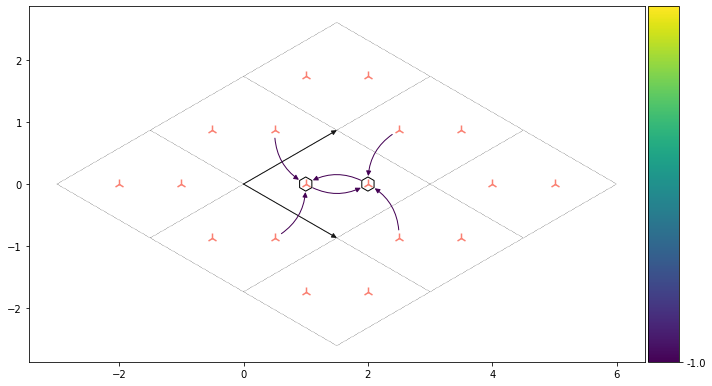

In [2]:
# Definition of the operator.
L = alfa.gallery.operators.graphene_tight_binding()

plt.figure(figsize=(10, 10))
L.plot()
plt.tight_layout()

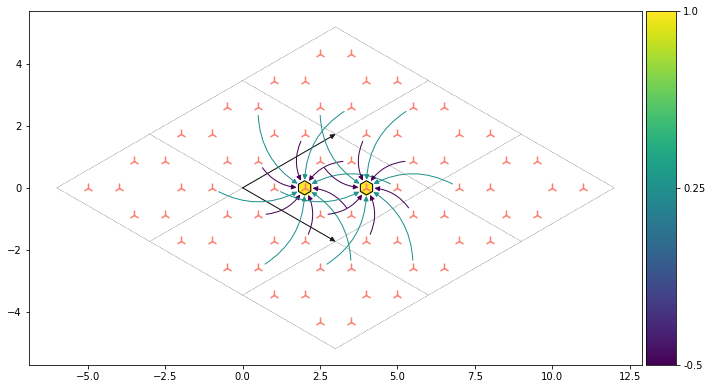

In [3]:
# definition of the restriction operator
R = alfa.gallery.operators.graphene_dirac_restriction(2, .25, .25)

plt.figure(figsize=(10, 10))
R.plot()
plt.tight_layout()

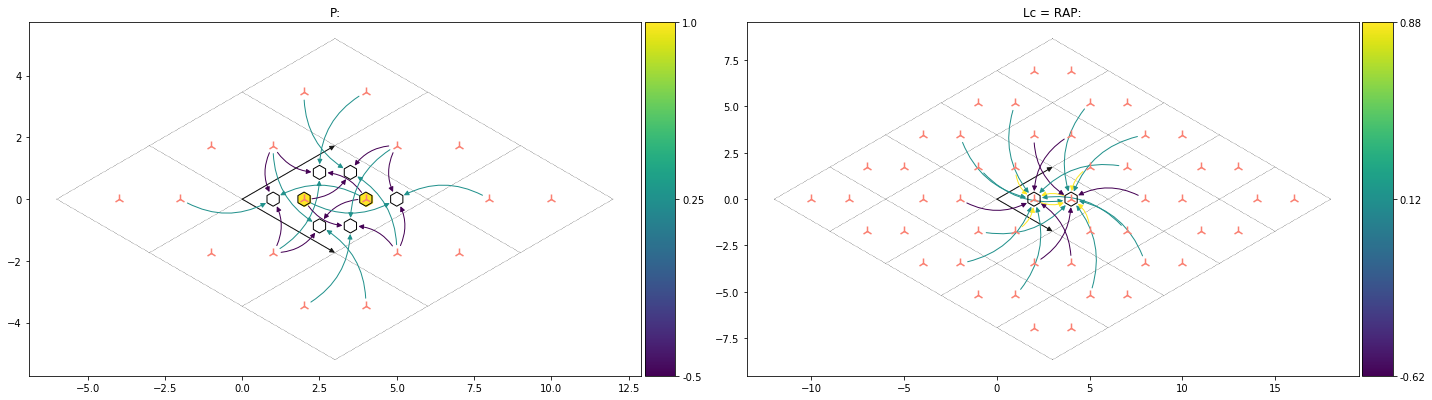

In [4]:
# From L and R we can compute all operators used in the Galerkin coarse grid correction

Id = alfa.tools.identity(L.C)  # identity
P = R.transpose()  # prolongation
Lc = R@L@P  # coarse grid operator.

# plot prolongation and coarse grid operator:
plt.figure(figsize=(20, 12))
plt.subplot(121)
P.plot()
plt.title("P:")
plt.subplot(122)
Lc.plot()
plt.title("Lc = RAP:")
plt.tight_layout()

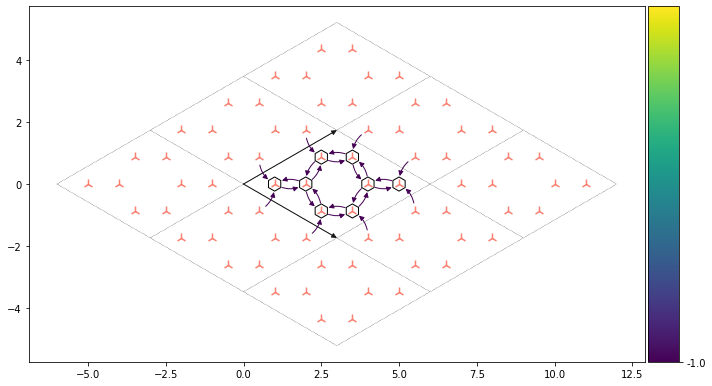

In [5]:
# Define the 4-color overlap smoother.

# Its translational invariance is exactly two times the translational-invariance of the tight-binding Hamiltonian

# First step: Rewrite the tight binding Hamiltonian w.r.t. to the Lattice 2A
slattice = alfa.Lattice(2*L.C.A)  # Define the translational invariance
Ls = L.wrt_lattice(slattice)  # algorithm "LatticeCoarsening" in the article.
Ls.normalize()  # algorithm "Normalize" in the article

# plot this operator.
plt.figure(figsize=(10, 10))
Ls.plot()
plt.tight_layout()

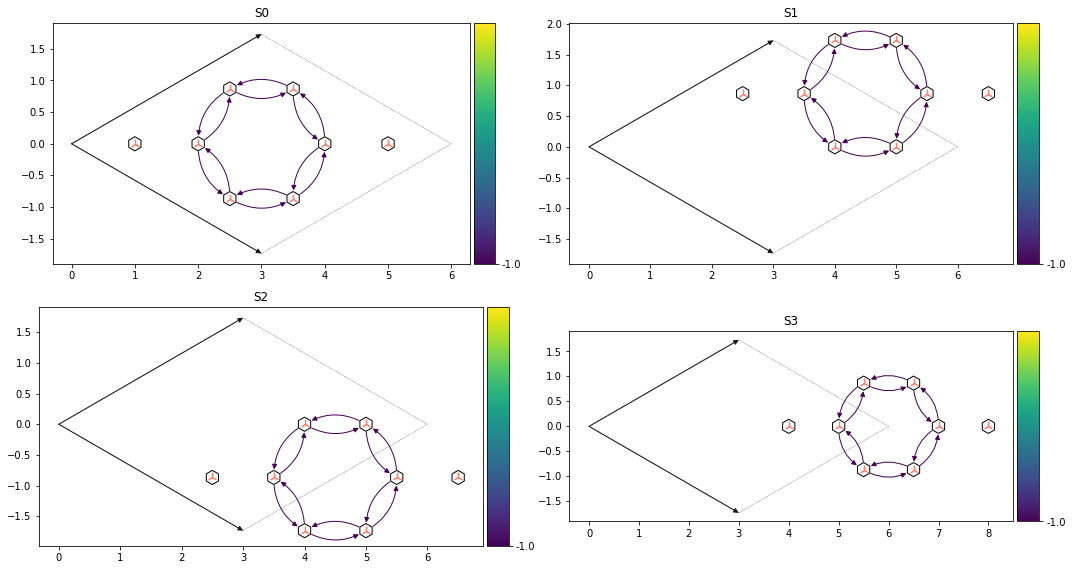

In [6]:
# Second: shift the operator Ls and extract the multiplier.

# The 8  atoms s_0,..,s_7 are ordered lexicographically. s_1,..,s_6 make up a complete hexagon.
idx = [1, 2, 3, 4, 5, 6]

# This hexagon is shifted to make up all four colors. In the article this is \tau^{(1)},...,\tau^{(4)}
shifts = [[0, 0], [1, 0],
          [0, 1], [1, 1]]

S = {}  # prepare a dictionary where we save the four operators.

for j in range(len(shifts)):
    # shift the operator Ls:
    # We rewrite the operator Ls w.r.t. to the shifted structure element
    Ls_shifted = Ls.change_structure_elements(
        [x + L.C.A@shifts[j] for x in Ls.C.s])  # Algorithm "ChangeStructureElement"
    # get the central multiplier m_p * m_L^{(0)} * m_p with (m_p)_ii = 1 if i in idx, =0 else.
    stmp = alfa.tools.central_multiplier_of(Ls_shifted, idx)

    S = {**S, **{'S' + str(j): stmp}}

# plot the smoothers S[j] before normalization.
plt.figure(figsize=(15, 8))
for j, key in enumerate(S):
    plt.subplot(2, 2, j+1)
    S[key].plot()
    plt.title(key)

plt.tight_layout()

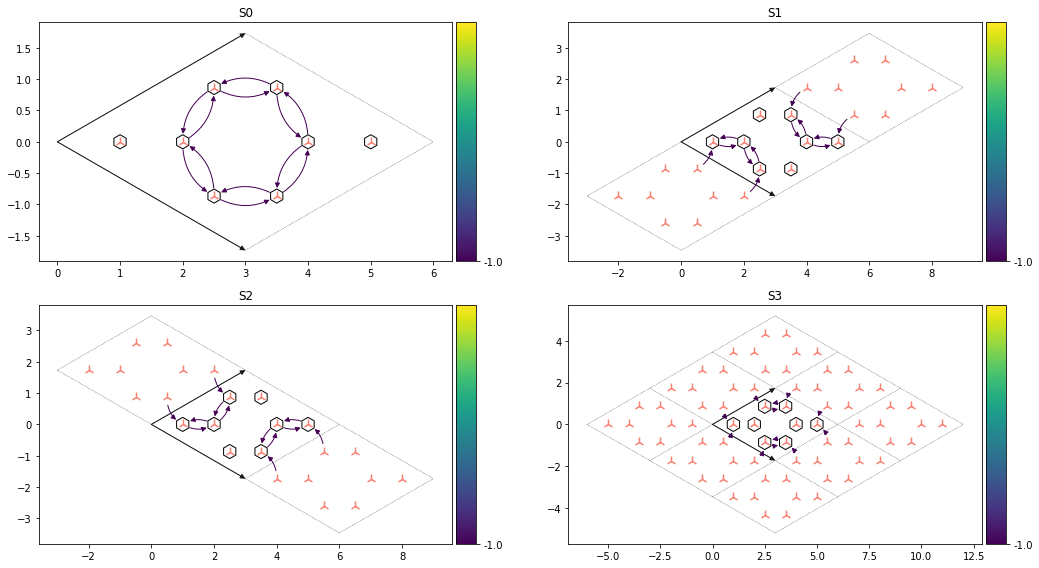

In [7]:
# plot after normalization.
plt.figure(figsize=(15, 8))
for j, key in enumerate(S):
    plt.subplot(2, 2, j+1)
    S[key].normalize()
    S[key].plot()
    plt.title(key)

plt.tight_layout()

In [8]:
# Construct the error propagator of the smoother (\product (I-.5*S_i^\dagger L) )
# and the two-grid correction as a string.
# This string is evaluated on the level of symbols.

X = {**{'I': Id, 'L': L, 'P': P, 'Lc': Lc, 'R': R}, **S}  # indices 0,1, .. 5

# Construct smoother string.
Gstr = ''
for i in [3, 2, 1, 0]:
    pinv_si_str = "pinv('S" + str(i) + "')"
    Gstr += "@('I' - .5*" + pinv_si_str + "@'L')"
Gstr = Gstr[1:]

# construct coarse grid correction string
Kstr = "('I' - 'P'@pinv('Lc')@'R'@'L')"

print("Smoother Gstr : " + Gstr)
print("Coarsegridcorrection Kstr : " + Kstr)

Smoother Gstr : ('I' - .5*pinv('S3')@'L')@('I' - .5*pinv('S2')@'L')@('I' - .5*pinv('S1')@'L')@('I' - .5*pinv('S0')@'L')
Coarsegridcorrection Kstr : ('I' - 'P'@pinv('Lc')@'R'@'L')


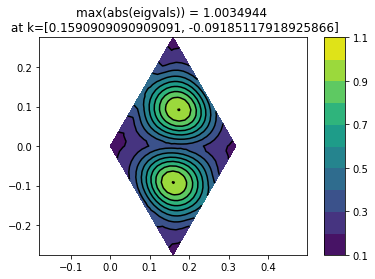

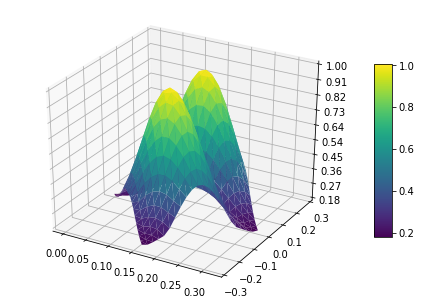

In [9]:
# analysis of the smoother.
smoother = alfa.Operator_Composition(X, Gstr)
smoother.compute_spectrum(22)  # resolution of the dual lattice: 22x22

# plot...
plt.figure()
smoother.plot_spectrum()
plt.figure()
smoother.plot_spectrum_3d()

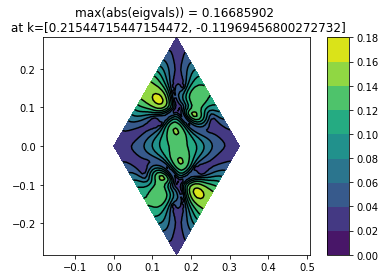

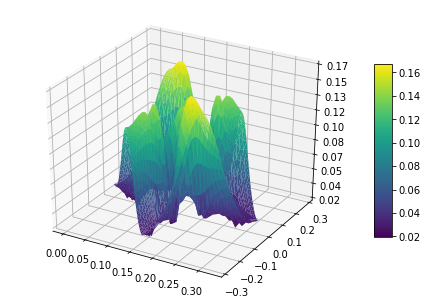

In [10]:
# analysis of the two-grid method
twogrid = alfa.Operator_Composition(X, Gstr + "@" + Kstr + "@" + Gstr)
twogrid.compute_spectrum(41)  # resolution of the dual lattice: 41x41

# plot...
plt.figure()
twogrid.plot_spectrum()
plt.figure()
twogrid.plot_spectrum_3d()